In [1]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from process_data import *
from models.transformer_cnn import *
from training import train
from evaluation import evaluate
import matplotlib.pyplot as plt

In [2]:
df_zoo_train, df_zoo_test = load_data("../data")
df_zoo_train.head()

,Record_id,Attribute_name,y_act,total_vals,num_nans,%_nans,num_of_dist_val,%_dist_val,mean,std_dev,...,mean_stopword_total,stdev_stopword_total,mean_char_count,stdev_char_count,mean_whitespace_count,stdev_whitespace_count,mean_delim_count,stdev_delim_count,is_list,is_long_sentence
0,33,Area,categorical,21477,0,0.0,174,0.810169,0.000000,0.000000,...,0.2,0.4,10.0,4.816638,0.4,0.8,0.4,0.8,False,False
1,33,Area Code,categorical,21477,0,0.0,174,0.810169,125.449411,72.866452,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,False,False
2,33,Element,categorical,21477,0,0.0,2,0.009312,0.000000,0.000000,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
3,33,Element Code,categorical,21477,0,0.0,2,0.009312,5211.687154,146.816661,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
4,33,Item,categorical,21477,0,0.0,115,0.535457,0.000000,0.000000,...,0.8,0.4,19.6,2.244994,2.0,0.0,2.0,0.0,False,False


In [4]:
columns = ["Attribute_name"] + ['sample_%d' % i for i in range(1, 6)]
train_data = preprocess(df_zoo_train, text_features=columns)
test_data = preprocess(df_zoo_test, text_features=columns)
train_data.head()

,text,features,label
0,Area [SEP] Afghanistan [SEP] Albania [SEP] Alg...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
1,Area Code [SEP] 2 [SEP] 3 [SEP] 4 [SEP] 7 [SEP] 8,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
2,Element [SEP] Food [SEP] Feed [SEP] Food [SEP]...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
3,Element Code [SEP] 5142 [SEP] 5521 [SEP] 5142 ...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
4,Item [SEP] Wheat and products [SEP] Rice (Mill...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0


In [5]:
x_train, x_val, y_train, y_val = train_test_split(train_data[['text', "features"]], train_data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_data['label'])

In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model_name = "bert_cnn"

In [8]:
device = torch.device("cuda")

In [9]:
for param in bert.parameters():
    param.requires_grad = False

In [10]:
train_dataloader, val_dataloader, test_dataloader = init_dataloaders(x_train, y_train, x_val, y_val, 
                                                                     test_data, model="bert")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

/home/tamittal/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
class Transformer_cnn(nn.Module):

    def __init__(self, transformer, num_kernels, kernel_sizes):

        super(Transformer_cnn, self).__init__()

        self.transformer = transformer 
    
        Co = num_kernels
        Ks = kernel_sizes
        
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, 768)) for K in Ks])
          
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(len(Ks) * Co + 19, 9)
        
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, features):

        #pass the inputs to the model 
        tf_out = self.transformer(sent_id, attention_mask=mask)
        
        x = tf_out.last_hidden_state
        
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        
        x = torch.cat(x, 1)
        
        conv_out = torch.cat([x, features], 1)
        
        x = self.dropout(conv_out)  
        
        x = self.fc1(x)  
        
        x = self.softmax(x)

        return x, conv_out

In [11]:
model = Transformer_cnn(bert, 256, [1, 2, 3, 5])

model = model.to(device)

In [16]:
# define the loss function
cross_entropy  = nn.NLLLoss() 

In [18]:
# set initial loss to infinite
best_valid_acc = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
valid_accuracies=[]

In [25]:
# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5)
# 1e-4 for 25 epochs
# 5e-5 for 10 epochs

In [26]:
# number of training epochs
epochs = 25

In [27]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _, = train(model, train_dataloader, optimizer, cross_entropy)
    
    #evaluate model
    valid_loss, _, valid_acc = evaluate(model, val_dataloader, cross_entropy, y_val)
    
    #save the best model
    if valid_acc >= best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), '../models/exports/%s.pt' % model_name)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.101
Validation Loss: 0.388
Validation Accuracy: 0.895

 Epoch 2 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.099
Validation Loss: 0.398
Validation Accuracy: 0.887

 Epoch 3 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.091
Validation Loss: 0.388
Validation Accuracy: 0.889

 Epoch 4 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.091
Validation Loss: 0.396
Validation Accuracy: 0.896

 Epoch 5 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.089
Validation Loss: 0.390
Validation Accuracy: 0.895

 Epoch 6 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evalua

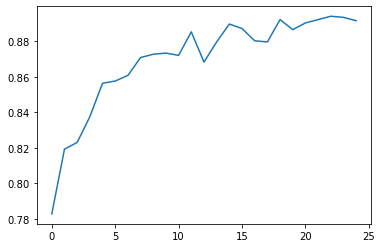

In [23]:
plt.plot(valid_accuracies)

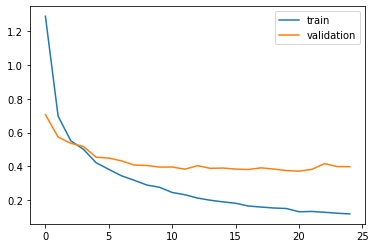

In [24]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train", "validation"])

In [17]:
valid_loss, _, valid_acc = evaluate(model, val_dataloader, cross_entropy, y_val)
print("validation_accuracy:", valid_acc)


Evaluating...
validation_accuracy: 0.9281663516068053


In [18]:
loss, preds, acc = evaluate(model,test_dataloader, cross_entropy, test_data["label"])
print("test_accuracy:", acc)


Evaluating...
  Batch    50  of     63.
test_accuracy: 0.9335012594458438


In [45]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

In [40]:
labels = [
    "numeric",
    "categorical",
    "datetime",
    "sentence",
    "url",
    "embedded-number",
    "list",
    "not-generalizable",
    "context-specific"]

In [36]:
confusion_matrix(test_data["label"], preds.argmax(axis=1))

array([[704,   1,   0,   0,   0,   0,   0,   1,   1],
       [  4, 431,   0,   6,   0,   0,   0,   7,   9],
       [  0,   0, 141,   0,   0,   0,   0,   0,   0],
       [  0,   4,   0,  79,   0,   0,   0,   8,   1],
       [  0,   0,   0,   0,  31,   0,   1,   0,   0],
       [  3,   0,   0,   1,   0,  94,   0,   0,   1],
       [  0,   2,   0,   2,   0,   0,  48,   2,   3],
       [  4,  15,   0,   4,   1,   1,   0, 184,   6],
       [ 19,   8,   0,   1,   0,   0,   1,  15, 141]])

<AxesSubplot:>

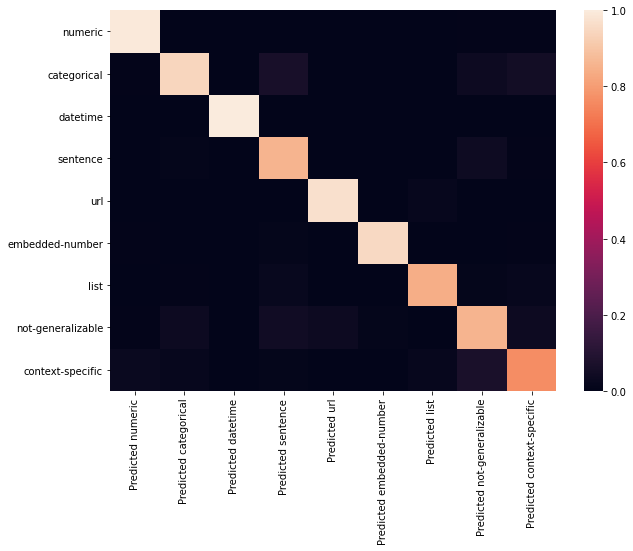

In [52]:
label_to_cat = {
    "numeric": 0,
    "categorical": 1,
    "datetime": 2,
    "sentence": 3,
    "url": 4,
    "embedded-number": 5,
    "list": 6,
    "not-generalizable": 7,
    "context-specific": 8
}
cm = confusion_matrix(test_data["label"], preds.argmax(axis=1))
cm = cm/cm.sum(axis=1)
df_matrix = pd.DataFrame(cm, index=[cat for cat in labels],
             columns=["Predicted %s" % cat for cat in labels])
plt.figure(figsize=(10,7))
sns.heatmap(df_matrix)

In [56]:
df_matrix.sum(axis=0)

Predicted numeric              1.038190
Predicted categorical          1.008753
Predicted datetime             1.000000
Predicted sentence             1.010870
Predicted url                  1.000000
Predicted embedded-number      0.959596
Predicted list                 0.877193
Predicted not-generalizable    1.009302
Predicted context-specific     0.875676
dtype: float64

In [50]:
cm.sum(axis=1)

array([707, 457, 141,  92,  32,  99,  57, 215, 185])

In [28]:
print(classification_report(test_data["label"], preds.argmax(axis=1), target_names=labels))

                   precision    recall  f1-score   support

          numeric       0.96      1.00      0.98       707
      categorical       0.93      0.94      0.94       457
         datetime       1.00      1.00      1.00       141
         sentence       0.85      0.86      0.85        92
              url       0.97      0.97      0.97        32
  embedded-number       0.99      0.95      0.97        99
             list       0.96      0.84      0.90        57
not-generalizable       0.85      0.86      0.85       215
 context-specific       0.87      0.76      0.81       185

         accuracy                           0.93      1985
        macro avg       0.93      0.91      0.92      1985
     weighted avg       0.93      0.93      0.93      1985



In [ ]:
loss, preds, acc = evaluate(model,test_dataloader, cross_entropy, test_data["label"])
print("test_accuracy:", acc)

In [20]:
torch.save(model.state_dict(), '../models/exports/%s_temp.pt' % model_name)

In [13]:
model.load_state_dict(torch.load("../experiments/exports/bert_cnn_256_1_2_3_5.pt"))

<All keys matched successfully>